## Transfomer
nn.init

In [26]:
"""%%bash
python3 -m pip install --user torch
python3 -m pip install --user scikit-learn
python3 -m pip install --user imblearn"""

'%%bash\npython3 -m pip install --user torch\npython3 -m pip install --user scikit-learn\npython3 -m pip install --user imblearn'

In [27]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.device_count()
#torch.set_default_tensor_type('torch.cuda.FloatTensor')

1

## Data定義

In [28]:
%%time
#6分ぐらいかかる
df_aal = pd.read_csv('../02_data_analysis/roi_timeseries/timeseries_aal.csv')
df_ho = pd.read_csv('../02_data_analysis/roi_timeseries/timeseries_ho.csv')

#df_dynamic_aal = pd.read_csv('../02_data_analysis/dynamic_FC/dynamic_aal.csv')
#df_dynamic_ho = pd.read_csv('../02_data_analysis/dynamic_FC/dynamic_ho.csv')

df_subjects_info = pd.read_csv('../02_data_analysis/subjects_info/subjects_info.csv')

CPU times: user 3 s, sys: 148 ms, total: 3.15 s
Wall time: 3.16 s


In [29]:
def make_info_data(df = df_subjects_info,col = ['Age','Sex','やる気スコア(Apathy scale)']):
    subID = np.array(df.subID)
    subjects_info_list = []
    for ID in subID:
        data = np.array(df[df.subID == ID][col])[0]
        if 'Sex' in col:
            idx = col.index('Sex')
            if data[idx] == '男':
                data[idx] = 0
            else:
                data[idx] = 1
        subjects_info_list.append(data)
    subjects_info = np.array(subjects_info_list)
    
    for i in range(len(col)):
        if i == idx:
            continue
        else:
            subjects_info[:,i] = (subjects_info[:,i] - np.mean(subjects_info[:,i]))/np.std(subjects_info[:,i])
    return subjects_info.astype(np.float)

def make_data(df, subID = df_subjects_info.subID ,remove_list = ['time','subID']):
    data_list = []
    df_cols = list(df.columns)
    for r in remove_list:
        try:
            df_cols.remove(r)
        except:
            pass
    for ID in df_subjects_info.subID:
        data = df[df.subID == ID][df_cols]
        data = np.array(data)
        data_list.append(data)
    data = np.array(data_list)
    return data

In [30]:
%%time
data_label = make_info_data()
data_aal = make_data(df_aal)
data_ho = make_data(df_ho)

data_label.shape
data_aal.shape
data_ho.shape

CPU times: user 10 s, sys: 36.7 ms, total: 10.1 s
Wall time: 10.1 s


(615, 140, 110)

In [31]:
"""%%time
#30秒ぐらいかかる
data_dynamic_aal = make_data(df_dynamic_aal)
data_dynamic_ho = make_data(df_dynamic_ho)

data_dynamic_aal.shape
data_dynamic_ho.shape"""

'%%time\n#30秒ぐらいかかる\ndata_dynamic_aal = make_data(df_dynamic_aal)\ndata_dynamic_ho = make_data(df_dynamic_ho)\n\ndata_dynamic_aal.shape\ndata_dynamic_ho.shape'

## Model作成

In [44]:
import math
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super(PositionalEncoding, self).__init__()
        
        self.dropout = nn.Dropout(p=dropout)
        # Not a parameter
        self.register_buffer('pe', self._pe_table(d_model, max_len))

    def _pe_table(self, d_model: int, max_len: int) -> torch.Tensor:
        pos = torch.arange(0, max_len).unsqueeze(1)
        pe_denominator = torch.exp(
            torch.arange(0, d_model, 2) * math.log(10000) / d_model
        )

        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(pos / pe_denominator)  # 偶数項にはsin
        pe[:, 1::2] = torch.cos(pos / pe_denominator)  # 奇数項にはcos

        pe = pe.unsqueeze(0)  # バッチに対応するため
        return pe

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.dropout(x + self.pe[:, :x.size(1)].clone().detach())
    

In [58]:
class Model(nn.Module):    
    def __init__(self,input_dim,hidden_dim,time_len,nhead,output_dim,hidden_dim_transformer):
        super(Model, self).__init__()
        self.fc   = nn.Linear(input_dim,hidden_dim)
        self.pos  = PositionalEncoding(d_model = hidden_dim,dropout=0.1)
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(hidden_dim,
                                                                    nhead,
                                                                    dropout=0.1,
                                                                    batch_first=True)
        self.transformer_encoder       = nn.TransformerEncoder(self.transformer_encoder_layer,
                                                               num_layers=hidden_dim_transformer)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,x):
        x = self.fc(x)
        x = self.pos(x)
        x = self.transformer_encoder(x)
        x = torch.mean(x,axis=2)
        x = torch.mean(x,axis=1)
        x = torch.reshape(x, (-1, 1))
        x = self.sigmoid(x)
        return x

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, label=None):
        self.data = data
        self.label = label
        self.test = label is None
        self.length = data.shape[0]
    def __len__(self):
        return self.length
    def __getitem__(self,idx):
        if self.test:
            data = torch.tensor(self.data[idx])
            return data
        else:
            data = torch.tensor(self.data[idx])
            label = torch.tensor(self.label[idx])
            return data, label

In [63]:
def train_model(data,label,epochs=1000,n_splits=5):
    
    epochs = epochs
    seed = 0
    
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    label_gender = np.array([label[:,1]]).T
    train_all, test, train_all_label, test_label = train_test_split(data,label_gender, train_size = 0.8 ,shuffle=False)
    
    test_dataset = MyDataset(test)
    test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=32)
    
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=n_splits)
    test_pred_all = []
    
    for i, (train_index, val_index) in enumerate(kf.split(train_all)):
        
        early_stopping = 1e5
        save_epochs = 0
        
        train_loss_plot = []
        val_loss_plot = []
        
        train, train_label = train_all[train_index], train_all_label[train_index]
        val,   val_label   = train_all[val_index],   train_all_label[val_index]
        
        input_dim  = train.shape[2]
        hidden_dim = 128
        time_len   = train.shape[1]
        nhead      = 16
        output_dim = train_label.shape[1]
        hidden_dim_transformer = 2
        
        train = train.reshape(train.shape[0],time_len,input_dim)
        train_label = train_label.reshape(train_label.shape[0],-1)
        
        train_dataset = MyDataset(train,train_label)
        train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True)

        val_dataset = MyDataset(val,val_label)
        val_dataloader = torch.utils.data.DataLoader(val_dataset,batch_size=32)
        
        model = Model(input_dim,hidden_dim,time_len,nhead,output_dim,hidden_dim_transformer).to(device)
        criterion = nn.BCELoss()
        
        """# 学習させるパラメータを、変数params_to_updateに格納する
        params_to_update = []
        # 学習させないパラメータ
        update_param_names = ["fc.weight", "fc.bias"]
        
        # 学習させるパラメータ以外は勾配計算をなくし、変化しないように設定
        for name, param in model.named_parameters():
            if name in update_param_names:
                param.requires_grad = False
                print(name)
            else:
                param.requires_grad = True
                params_to_update.append(param)
                
        optimizer = torch.optim.AdamW(params_to_update)"""
        optimizer = torch.optim.AdamW(model.parameters(),lr = 1e-4)
        
        def compute_loss(y, t):
            return criterion(y, t)

        def train_step(x,t):
            model.train()
            preds = model(x)
            loss = compute_loss(preds, t)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            return loss, preds

        def val_step(x,t):
            model.eval()
            preds = model(x)
            loss = compute_loss(preds, t)    
            return loss, preds

        def test_step(x):
            model.eval()
            preds = model(x)
            return preds

        for epoch in range(epochs):
            train_loss = 0.
            val_loss = 0.
            
            for (x, t) in train_dataloader:
                x, t = x.to(device), t.to(device)
                x = x.float()
                t = t.float()
                loss, preds = train_step(x,t)
                train_loss += loss.item()
            
            for (x, t) in val_dataloader:
                x, t = x.to(device), t.to(device)
                x = x.float()
                t = t.float()
                loss, preds = val_step(x,t)
                val_loss += loss.item()
                
            train_loss /= len(train_dataloader)
            val_loss /= len(val_dataloader)
            if (epoch+1) % 100 == 0:
                print(f'Kfold: {i+1} ::: epoch: {epoch+1}, loss: {train_loss}, val loss: {val_loss}')
            
            if epoch+1 >=100:
                if early_stopping >= val_loss:
                    early_stopping = val_loss
                    model_path = '../02_data_analysis/model/model_gender.pth'
                    torch.save(model.state_dict(), model_path)
                    save_epochs = epoch+1
            
            train_loss_plot.append(train_loss)
            val_loss_plot.append(val_loss)
        
        model.load_state_dict(torch.load(model_path))
        print(f'save_epochs:{save_epochs}')
        
        train_loss_plot = np.array(train_loss_plot)
        val_loss_plot   = np.array(val_loss_plot)
        x               = np.linspace(0, len(train_loss_plot), len(train_loss_plot))
        
        plt.plot(x, train_loss_plot, label="train loss")
        plt.plot(x, val_loss_plot, label="val loss")
        plt.grid()
        plt.show()
        
        train_pred = []
        train_label = []
        
        for (x, t) in train_dataloader:
            x, t = x.to(device), t.to(device)
            x = x.float()
            t = t.float()
            loss, preds = train_step(x,t)
            train_pred.append(preds)
            train_label.append(t)
            
        val_pred = []
        for (x, t) in val_dataloader:
            x, t = x.to(device), t.to(device)
            x = x.float()
            t = t.float()
            loss, preds = val_step(x,t)
            val_pred.append(preds)
        
        train_pred = torch.cat(train_pred)
        train_pred = train_pred.to('cpu').detach().numpy().copy()
        
        train_label = torch.cat(train_label)
        train_label = train_label.to('cpu').detach().numpy().copy()
        
        val_pred = torch.cat(val_pred)
        val_pred = val_pred.to('cpu').detach().numpy().copy()
        
        plt.scatter(train_label[:,0],np.array(train_pred[:,0]))
        plt.show()
        print(np.mean(train_label[:,0]))
        print(np.corrcoef(train_label[:,0],np.array(train_pred[:,0])))
        
        plt.scatter(val_label[:,0],np.array(val_pred[:,0]))
        plt.show()
        print(np.corrcoef(val_label[:,0],np.array(val_pred[:,0])))
                
        test_pred = []
        for x in test_dataloader:
            x = x.to(device)
            x = x.float()
            preds = test_step(x)
            test_pred.append(preds)
        test_pred = torch.cat(test_pred)
        test_pred = test_pred.to('cpu').detach().numpy().copy()
        test_pred_all.append(test_pred)
    return np.array(test_pred_all),test_label

Kfold: 1 ::: epoch: 100, loss: 0.6387539505958557, val loss: 0.6820366531610489
Kfold: 1 ::: epoch: 200, loss: 0.5765268573394189, val loss: 0.6711789667606354
Kfold: 1 ::: epoch: 300, loss: 0.5277569385675284, val loss: 0.6700594127178192
Kfold: 1 ::: epoch: 400, loss: 0.4771910355641292, val loss: 0.6880012154579163
Kfold: 1 ::: epoch: 500, loss: 0.4329929443506094, val loss: 0.6827463656663895
Kfold: 1 ::: epoch: 600, loss: 0.3923581150861887, val loss: 0.6824623346328735
Kfold: 1 ::: epoch: 700, loss: 0.3628590703010559, val loss: 0.7071416974067688
Kfold: 1 ::: epoch: 800, loss: 0.32602420907754165, val loss: 0.7307068705558777
Kfold: 1 ::: epoch: 900, loss: 0.2987723190050859, val loss: 0.7528498619794846
Kfold: 1 ::: epoch: 1000, loss: 0.2703255048164955, val loss: 0.7955551147460938
Kfold: 1 ::: epoch: 1100, loss: 0.24652278767182276, val loss: 0.8020306080579758
Kfold: 1 ::: epoch: 1200, loss: 0.23136038505114043, val loss: 0.8299547433853149
Kfold: 1 ::: epoch: 1300, loss: 0.

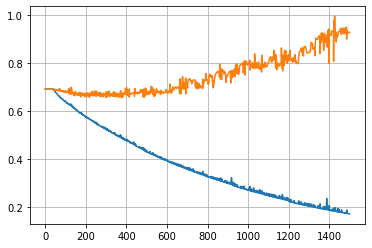

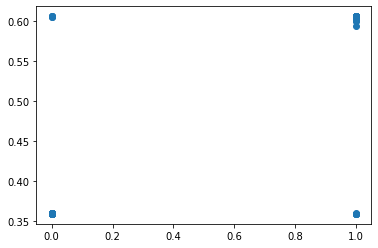

0.4707379
[[1.         0.94373187]
 [0.94373187 1.        ]]


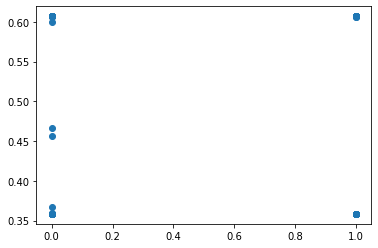

[[1.         0.16642133]
 [0.16642133 1.        ]]
Kfold: 2 ::: epoch: 100, loss: 0.6562862304540781, val loss: 0.6796151101589203
Kfold: 2 ::: epoch: 200, loss: 0.5877716220342196, val loss: 0.6787841022014618
Kfold: 2 ::: epoch: 300, loss: 0.5346443011210515, val loss: 0.6699168533086777
Kfold: 2 ::: epoch: 400, loss: 0.48600196609130275, val loss: 0.6676312386989594
Kfold: 2 ::: epoch: 500, loss: 0.4476951223153334, val loss: 0.6835615634918213
Kfold: 2 ::: epoch: 600, loss: 0.40517353782287013, val loss: 0.6953524053096771
Kfold: 2 ::: epoch: 700, loss: 0.3684419829111833, val loss: 0.6925818622112274
Kfold: 2 ::: epoch: 800, loss: 0.33688918214577895, val loss: 0.6870144456624985
Kfold: 2 ::: epoch: 900, loss: 0.31438883680563706, val loss: 0.7113811522722244
Kfold: 2 ::: epoch: 1000, loss: 0.2795149890276102, val loss: 0.7331476807594299
Kfold: 2 ::: epoch: 1100, loss: 0.2573937028646469, val loss: 0.7916117012500763
Kfold: 2 ::: epoch: 1200, loss: 0.23738402701341188, val loss: 

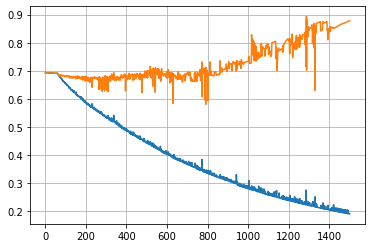

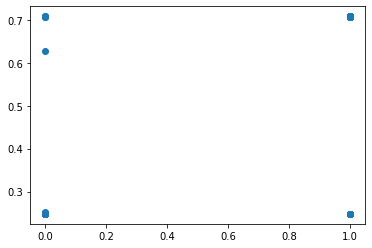

0.45038167
[[1.         0.93485561]
 [0.93485561 1.        ]]


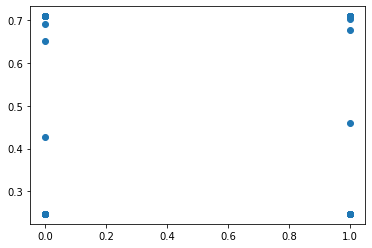

[[1.         0.25913482]
 [0.25913482 1.        ]]
Kfold: 3 ::: epoch: 100, loss: 0.6464031843038706, val loss: 0.6601559966802597
Kfold: 3 ::: epoch: 200, loss: 0.576625237098107, val loss: 0.6327716261148453
Kfold: 3 ::: epoch: 300, loss: 0.5287237671705393, val loss: 0.6204031184315681
Kfold: 3 ::: epoch: 400, loss: 0.4794003459123465, val loss: 0.6090790033340454
Kfold: 3 ::: epoch: 500, loss: 0.4397037304364718, val loss: 0.5992260426282883
Kfold: 3 ::: epoch: 600, loss: 0.40252437499853283, val loss: 0.5821346640586853
Kfold: 3 ::: epoch: 700, loss: 0.36889965488360477, val loss: 0.5907882302999496
Kfold: 3 ::: epoch: 800, loss: 0.3373132531459515, val loss: 0.6008917987346649
Kfold: 3 ::: epoch: 900, loss: 0.3101878303747911, val loss: 0.6112854182720184
Kfold: 3 ::: epoch: 1000, loss: 0.28361279001602757, val loss: 0.6192901059985161
Kfold: 3 ::: epoch: 1100, loss: 0.26144426144086397, val loss: 0.630818746984005
Kfold: 3 ::: epoch: 1200, loss: 0.24158227558319384, val loss: 0.

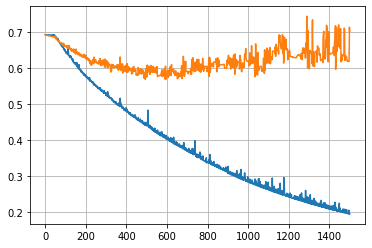

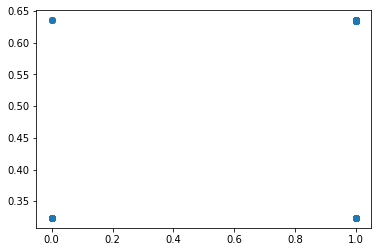

0.46192893
[[1.        0.9340323]
 [0.9340323 1.       ]]


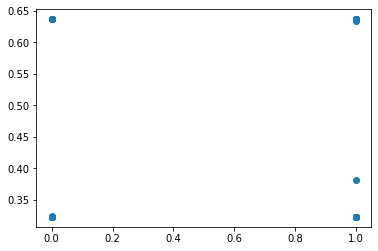

[[1.        0.3615608]
 [0.3615608 1.       ]]
Kfold: 4 ::: epoch: 100, loss: 0.6494634701655462, val loss: 0.696551963686943
Kfold: 4 ::: epoch: 200, loss: 0.5854863065939683, val loss: 0.7051364779472351
Kfold: 4 ::: epoch: 300, loss: 0.5315328011145959, val loss: 0.7015730142593384
Kfold: 4 ::: epoch: 400, loss: 0.49600954009936404, val loss: 0.7022170722484589
Kfold: 4 ::: epoch: 500, loss: 0.443182131418815, val loss: 0.7329550385475159
Kfold: 4 ::: epoch: 600, loss: 0.40395671129226685, val loss: 0.749010294675827
Kfold: 4 ::: epoch: 700, loss: 0.3780750953234159, val loss: 0.7472349852323532
Kfold: 4 ::: epoch: 800, loss: 0.3381328055491814, val loss: 0.7568420171737671
Kfold: 4 ::: epoch: 900, loss: 0.31192397154294527, val loss: 0.7824870496988297
Kfold: 4 ::: epoch: 1000, loss: 0.29396901107751405, val loss: 0.6283337324857712
Kfold: 4 ::: epoch: 1100, loss: 0.24946793913841248, val loss: 0.6900902539491653
Kfold: 4 ::: epoch: 1200, loss: 0.2173652476989306, val loss: 0.72306

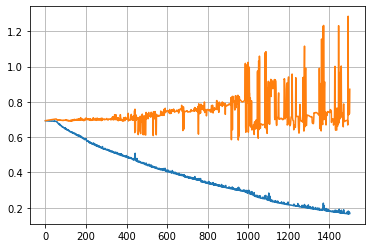

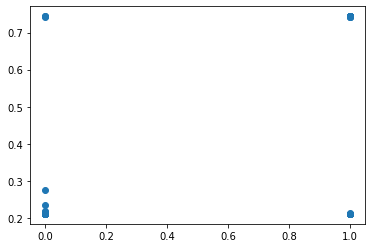

0.44162437
[[1.         0.93833719]
 [0.93833719 1.        ]]


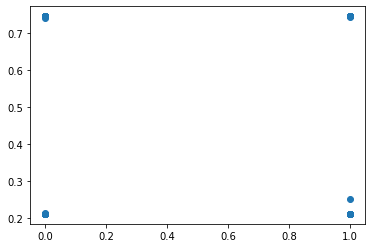

[[1.         0.14899486]
 [0.14899486 1.        ]]
Kfold: 5 ::: epoch: 100, loss: 0.6355599302511948, val loss: 0.7053528130054474
Kfold: 5 ::: epoch: 200, loss: 0.5786210023439847, val loss: 0.7149572968482971
Kfold: 5 ::: epoch: 300, loss: 0.5268666102336004, val loss: 0.7181774228811264
Kfold: 5 ::: epoch: 400, loss: 0.4808469552260179, val loss: 0.6821115612983704
Kfold: 5 ::: epoch: 500, loss: 0.4421019508288457, val loss: 0.6919067949056625
Kfold: 5 ::: epoch: 600, loss: 0.4030897823663858, val loss: 0.6845346987247467
Kfold: 5 ::: epoch: 700, loss: 0.3658927151790032, val loss: 0.7050020098686218
Kfold: 5 ::: epoch: 800, loss: 0.3354860223256625, val loss: 0.8159875720739365
Kfold: 5 ::: epoch: 900, loss: 0.30971604814896214, val loss: 0.7750812023878098
Kfold: 5 ::: epoch: 1000, loss: 0.2835153662241422, val loss: 0.7925432920455933
Kfold: 5 ::: epoch: 1100, loss: 0.2611530858736772, val loss: 0.8036900758743286
Kfold: 5 ::: epoch: 1200, loss: 0.2401681932119223, val loss: 0.84

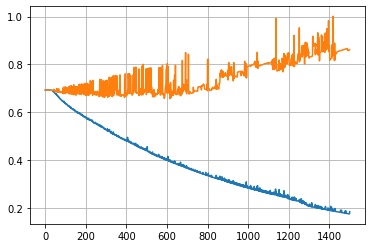

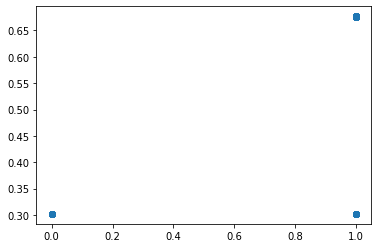

0.4720812
[[1.         0.95018071]
 [0.95018071 1.        ]]


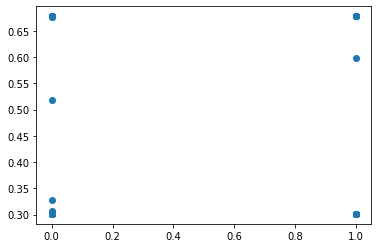

[[1.         0.34796863]
 [0.34796863 1.        ]]


In [65]:
test_pred,test_label = train_model(data_aal,data_label,epochs=1500,n_splits=5)